In [ ]:
import os
import glob
import pandas as pd
import numpy as np
import shutil
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
sns.set(rc={'figure.figsize':(10,6)})
sns.set(font_scale=1.3)
plt.style.use('fivethirtyeight')


!pip install -U -q pyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

from google.colab import drive
drive.mount('/content/gdrive')


!pip install tensorflow

!pip install -q keras

from sklearn.model_selection import train_test_split
# Backend
from keras import backend as K
# Utils
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from tensorflow.keras import layers
from keras.layers import concatenate
from tensorflow.keras.utils import plot_model
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation , BatchNormalization
#from keras.utils.data_utils import get_file
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

import warnings
warnings.filterwarnings(action="ignore")

In [ ]:
! pip install split-folders

In [ ]:
import splitfolders

In [ ]:
input_folder ="/content/gdrive/MyDrive/Colab Notebooks/data1"

output ="/content/gdrive/MyDrive/Colab Notebooks/data2"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(0.7, 0.3), group_prefix=None)

Copying files: 5631 files [17:44,  5.29 files/s]


In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/gdrive/MyDrive/Colab Notebooks/data2/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 shuffle=True)

Found 3941 images belonging to 4 classes.


In [ ]:
# test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale = 1./255)
# test_set = test_datagen.flow_from_directory('/working/dataset/test',
#                                             target_size = (224, 224),
#                                             batch_size = 32,
#                                             class_mode = 'categorical')

In [ ]:
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,rescale = 1./255)
val_set = val_datagen.flow_from_directory('/content/gdrive/MyDrive/Colab Notebooks/data2/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False)

Found 1690 images belonging to 4 classes.


In [ ]:
early = EarlyStopping(monitor='val_loss',patience=5)
reduce = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, mil_lr=0.001)

In [ ]:
output_classes = 4
batch_size = 32
epochs = 10
image_shape=(224,224,3)
nb_train_samples = 3941
nb_validation_samples = 1690
# nb_test_samples = 564

In [ ]:
# Building the Inception Model Architecture

def InceptionV4():

    input_layer = Input(shape=image_shape)

    x = stemBlock(prev_layer=input_layer)

    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)
    x = InceptionBlock_A(prev_layer=x)

    x = reduction_A_Block(prev_layer=x)

    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)
    x = InceptionBlock_B(prev_layer=x)

    x = reduction_B_Block(prev_layer= x)

    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)
    x = InceptionBlock_C(prev_layer=x)

    x = GlobalAveragePooling2D()(x)

    x = Dense(units = 1024, activation='relu') (x)
    x = Dropout(rate = 0.8) (x)
    x = Dense(units = output_classes, activation='softmax')(x)

    model = Model(inputs = input_layer , outputs = x , name ='Inception-V4')

    return model


def conv2d_with_Batch(prev_layer , nbr_kernels , filter_size , strides = (1,1) , padding = 'valid'):
    x = Conv2D(filters = nbr_kernels, kernel_size = filter_size, strides=strides , padding=padding) (prev_layer)
    x = BatchNormalization()(x)
    x = Activation(activation = 'relu') (x)
    return x


def stemBlock(prev_layer):
    x = conv2d_with_Batch(prev_layer, nbr_kernels = 32, filter_size = (3,3), strides = (2,2))
    x = conv2d_with_Batch(x, nbr_kernels = 32, filter_size = (3,3))
    x = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (3,3))

    x_1 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (3,3), strides = (2,2) )
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (1,7) , padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 64, filter_size = (7,1), padding ='same')
    x_1 = conv2d_with_Batch(x_1, nbr_kernels = 96, filter_size = (3,3))

    x_2 = conv2d_with_Batch(x, nbr_kernels = 96, filter_size = (1,1))
    x_2 = conv2d_with_Batch(x_2, nbr_kernels = 96, filter_size = (3,3))

    x = concatenate([x_1 , x_2], axis = 3)

    x_1 = conv2d_with_Batch(x, nbr_kernels = 192, filter_size = (3,3) , strides=2)
    x_2 = MaxPool2D(pool_size=(3,3) , strides=(2,2) ) (x)

    x = concatenate([x_1 , x_2], axis = 3)

    return x


def reduction_A_Block(prev_layer) :
    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (3,3) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,3) , strides=(2,2))

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (3,3) , strides=(2,2))

    x_3 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x = concatenate([x_1 , x_2 , x_3], axis = 3)

    return x


def reduction_B_Block(prev_layer):
    x_1 = MaxPool2D(pool_size=(3,3) , strides=(2,2))(prev_layer)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 192, filter_size = (3,3) , strides=(2,2) )

    x_3 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1) )
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = (1,7) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (7,1) , padding='same')
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 320, filter_size = (3,3) , strides=(2,2))

    x = concatenate([x_1 , x_2 , x_3], axis = 3)
    return x


def InceptionBlock_A(prev_layer): #I'm Here

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1), padding='same' )
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 96, filter_size = (3,3) , strides=(1,1) , padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 64, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 96, filter_size = (3,3) , padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 96, filter_size = (1,1) , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 96, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output


def InceptionBlock_B(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 192, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 224, filter_size = (7,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,7), padding='same')

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 192, filter_size = (1,1))
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 224, filter_size = (1,7) , padding='same')
    x_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (7,1), padding='same')

    x_3 = AveragePooling2D(pool_size=(3,3) , strides=1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 128, filter_size = (1,1))

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))

    output = concatenate([x_1 , x_2 ,x_3, x_4], axis = 3)
    return output


def InceptionBlock_C(prev_layer):

    x_1 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 448, filter_size = (3,1) , padding='same')
    x_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 512, filter_size = (1,3) , padding='same')
    x_1_1 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_1_2 = conv2d_with_Batch(prev_layer = x_1, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_1 = concatenate([x_1_1 , x_1_2], axis = 3)

    x_2 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 384, filter_size = (1,1))
    x_2_1 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (1,3), padding='same')
    x_2_2 = conv2d_with_Batch(prev_layer = x_2, nbr_kernels = 256, filter_size = (3,1), padding='same')
    x_2 = concatenate([x_2_1 , x_2_2], axis = 3)

    x_3 = MaxPool2D(pool_size=(3,3),strides = 1 , padding='same')(prev_layer)
    x_3 = conv2d_with_Batch(prev_layer = x_3, nbr_kernels = 256, filter_size = 3  , padding='same')

    x_4 = conv2d_with_Batch(prev_layer = prev_layer, nbr_kernels = 256, filter_size = (1,1))

    output = concatenate([x_1 , x_2 , x_3 , x_4], axis = 3)

    return output

In [ ]:
# Building the Inception V4 Model Architecture

model = InceptionV4()

# Checking Model Summary
model.summary()

Model: "Inception-V4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
adam_opt=Adam(lr = 0.00001, beta_1=0.6, beta_2=0.9,amsgrad=True)

# Compiling the Model
model.compile(optimizer= adam_opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

In [ ]:
import time
print("Training started it takes few minutes")
start_time = time.time()

history = model.fit(
  training_set,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = val_set,
  validation_steps = nb_validation_samples // batch_size,
  callbacks = [early, reduce])

print("successfully completed the traing session")
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Training started it takes few minutes
Epoch 1/10
123/123 [==============================] - 216s 834ms/step - loss: 0.7863 - accuracy: 0.7224 - val_loss: 2.4461 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 2/10
123/123 [==============================] - 92s 742ms/step - loss: 0.5850 - accuracy: 0.8376 - val_loss: 5.6261 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 3/10
123/123 [==============================] - 92s 740ms/step - loss: 0.4242 - accuracy: 0.8849 - val_loss: 1.8443 - val_accuracy: 0.5024 - lr: 0.0010
Epoch 4/10
123/123 [==============================] - 92s 742ms/step - loss: 0.3242 - accuracy: 0.9051 - val_loss: 1.3873 - val_accuracy: 0.6190 - lr: 0.0010
Epoch 5/10
123/123 [==============================] - 97s 783ms/step - loss: 0.2788 - accuracy: 0.9138 - val_loss: 1.4907 - val_accuracy: 0.5715 - lr: 0.0010
Epoch 6/10
123/123 [==============================] - 92s 743ms/step - loss: 0.2520 - accuracy: 0.9233 - val_loss: 0.2775 - val_accuracy: 0.9008 - lr: 0.0010
Epoch 7/10
12

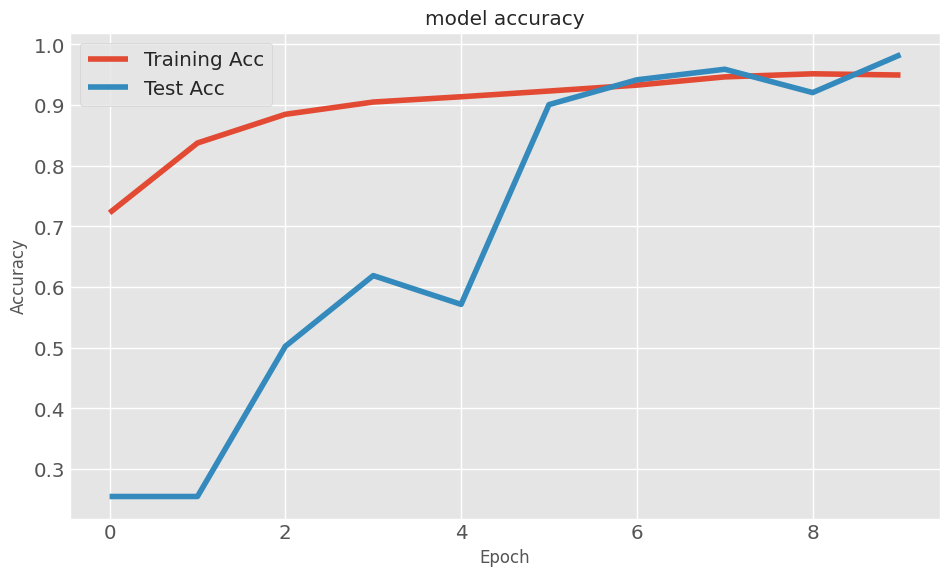

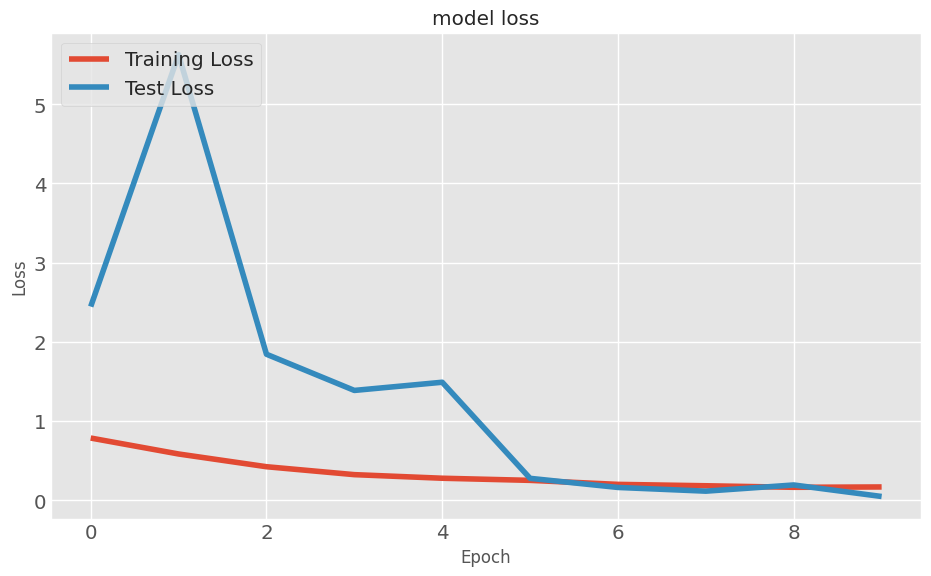

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate_generator(val_set, steps=50)

print ('Validation Score: ', score[0])
print ('Validation Accuracy: ',score[1])

Validation Score:  0.05020074546337128
Validation Accuracy:  0.9825000166893005


In [ ]:
# accuracy_score = model.evaluate_generator(test_set, steps=50)
# print("Accuracy Score:", accuracy_score[0])
# print("Accuracy:",accuracy_score[1])

In [ ]:
_, acc = model.evaluate(val_set, verbose=1)
print('> %.3f' % (acc * 100.0))

53/53 [==============================] - 13s 246ms/step - loss: 0.0476 - accuracy: 0.9834
> 98.343


In [ ]:
model.save("Test" + '.h5')

### Model Evaluation

The evaluate_model function loads a trained model from a saved file and evaluates it using the validation generator. It calculates overall metrics (accuracy, precision, recall, F1-score) and class-specific metrics. These metrics provide a detailed view of model performance.

In [ ]:
def evaluate_model(saved_model_path, validation_generator):
    # Load the saved model
    loaded_model = tf.keras.models.load_model(saved_model_path)

    # Evaluate the model on the test set
    test_loss, test_accuracy = loaded_model.evaluate(validation_generator)
    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_accuracy)

    # Perform thorough evaluation
    y_true = validation_generator.classes
    y_pred = loaded_model.predict(validation_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate overall metrics
    accuracy = metrics.accuracy_score(y_true, y_pred_classes)
    precision = metrics.precision_score(y_true, y_pred_classes, average='weighted')
    recall = metrics.recall_score(y_true, y_pred_classes, average='weighted')
    f1_score = metrics.f1_score(y_true, y_pred_classes, average='weighted')

    print('Overall Metrics:')
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1-Score:', f1_score)

    # Calculate metrics per class
    class_metrics = metrics.classification_report(y_true, y_pred_classes, target_names=validation_generator.class_indices.keys())
    print('\nMetrics per Class:')
    print(class_metrics)

In [ ]:
import sklearn.metrics as metrics
saved_model_path = '/content/gdrive/MyDrive/Colab Notebooks/Test.h5'

evaluate_model(saved_model_path, val_set)
# plot_training_history(history)

53/53 [==============================] - 14s 206ms/step - loss: 5.4194 - accuracy: 0.2609
Test Loss: 5.419363498687744
Test Accuracy: 0.26094675064086914
53/53 [==============================] - 10s 173ms/step
Overall Metrics:
Accuracy: 0.26094674556213016
Precision: 0.08668296561152046
Recall: 0.26094674556213016
F1-Score: 0.11316242952150017

Metrics per Class:
              precision    recall  f1-score   support

      cloudy       0.26      0.98      0.42       450
      desert       0.00      0.00      0.00       340
  green_area       0.00      0.00      0.00       450
       water       0.06      0.00      0.01       450

    accuracy                           0.26      1690
   macro avg       0.08      0.24      0.11      1690
weighted avg       0.09      0.26      0.11      1690

